In [37]:
import pandas as pd
import numpy as np
import scipy
import sklearn.cluster
from PIL import Image
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

In [3]:
#pick up the 1st image to have a look   
path_now = path[0]
a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))

In [4]:
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

In [5]:
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [6]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


In [7]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=0

815


In [8]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

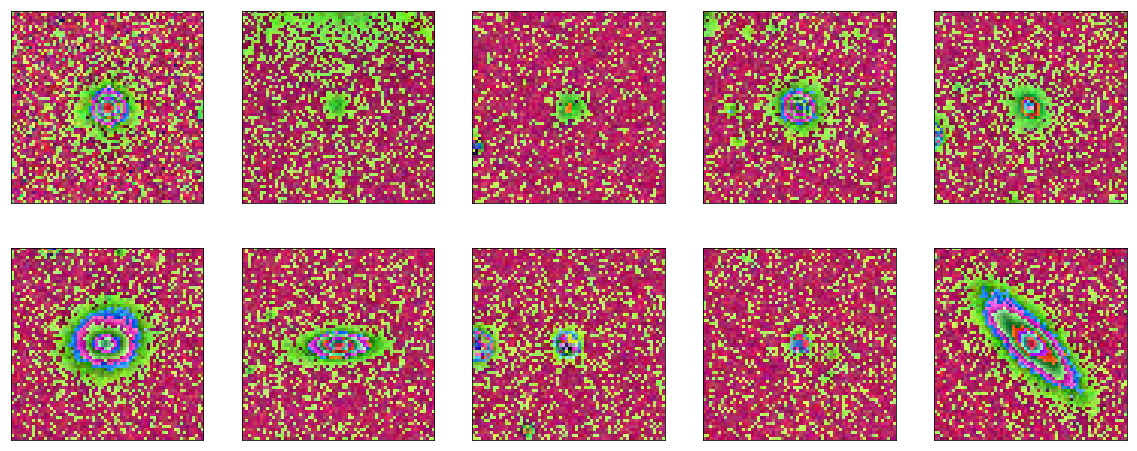

[1 1 1 1 1 1 1 0 2 1]


In [9]:
n=5
plt.figure(figsize=(20, 20*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

In [10]:
label = np_utils.to_categorical(Class, 3)

In [11]:
data = Image_RGB

In [12]:
train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
total  14142  samples


In [23]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [24]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 500 samples
Epoch 1/10
8000/8000 [==============================] - 12s - loss: -7230.5477 - val_loss: -7647.2225
Epoch 2/10
8000/8000 [==============================] - 11s - loss: -7513.1709 - val_loss: -7846.3022
Epoch 3/10
8000/8000 [==============================] - 11s - loss: -7901.7501 - val_loss: -7941.9627
Epoch 4/10
8000/8000 [==============================] - 11s - loss: -7944.7112 - val_loss: -7917.9608
Epoch 5/10
8000/8000 [==============================] - 11s - loss: -7981.2548 - val_loss: -7874.7288
Epoch 6/10
8000/8000 [==============================] - 11s - loss: -7984.8734 - val_loss: -7952.1296
Epoch 7/10
8000/8000 [==============================] - 11s - loss: -8012.7215 - val_loss: -7972.9474
Epoch 8/10
8000/8000 [==============================] - 11s - loss: -7990.9333 - val_loss: -7937.4254
Epoch 9/10
8000/8000 [==============================] - 11s - loss: -8015.3204 - val_loss: -7899.0913
Epoch 10/10
8000/8000 [============

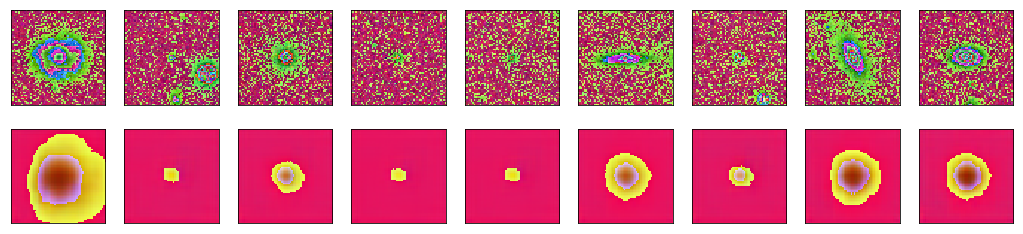

In [25]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[8000:9000],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

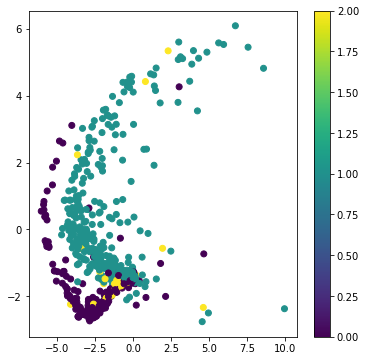

In [26]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 0.17 sec
modified: 0.3 sec
Isomap: 0.5 sec
MDS: 2.2 sec
SpectralEmbedding: 0.23 sec
t-SNE: 3.2 sec


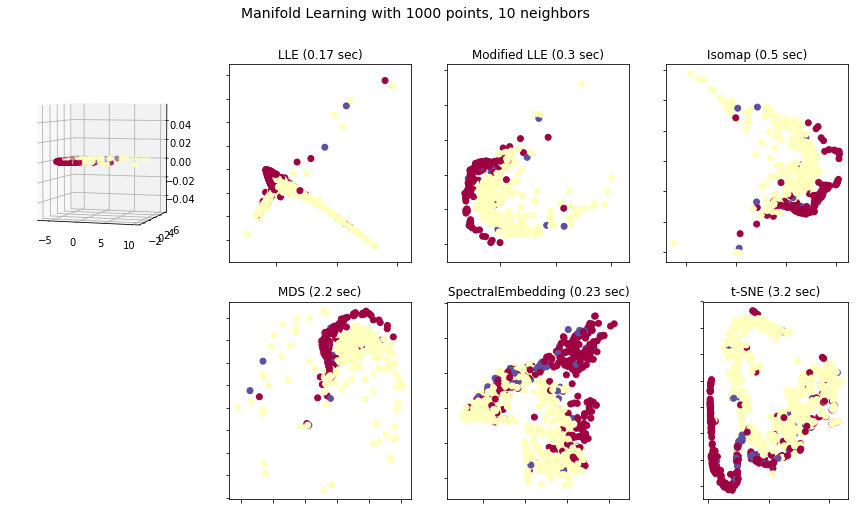

In [27]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:9000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [28]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [29]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

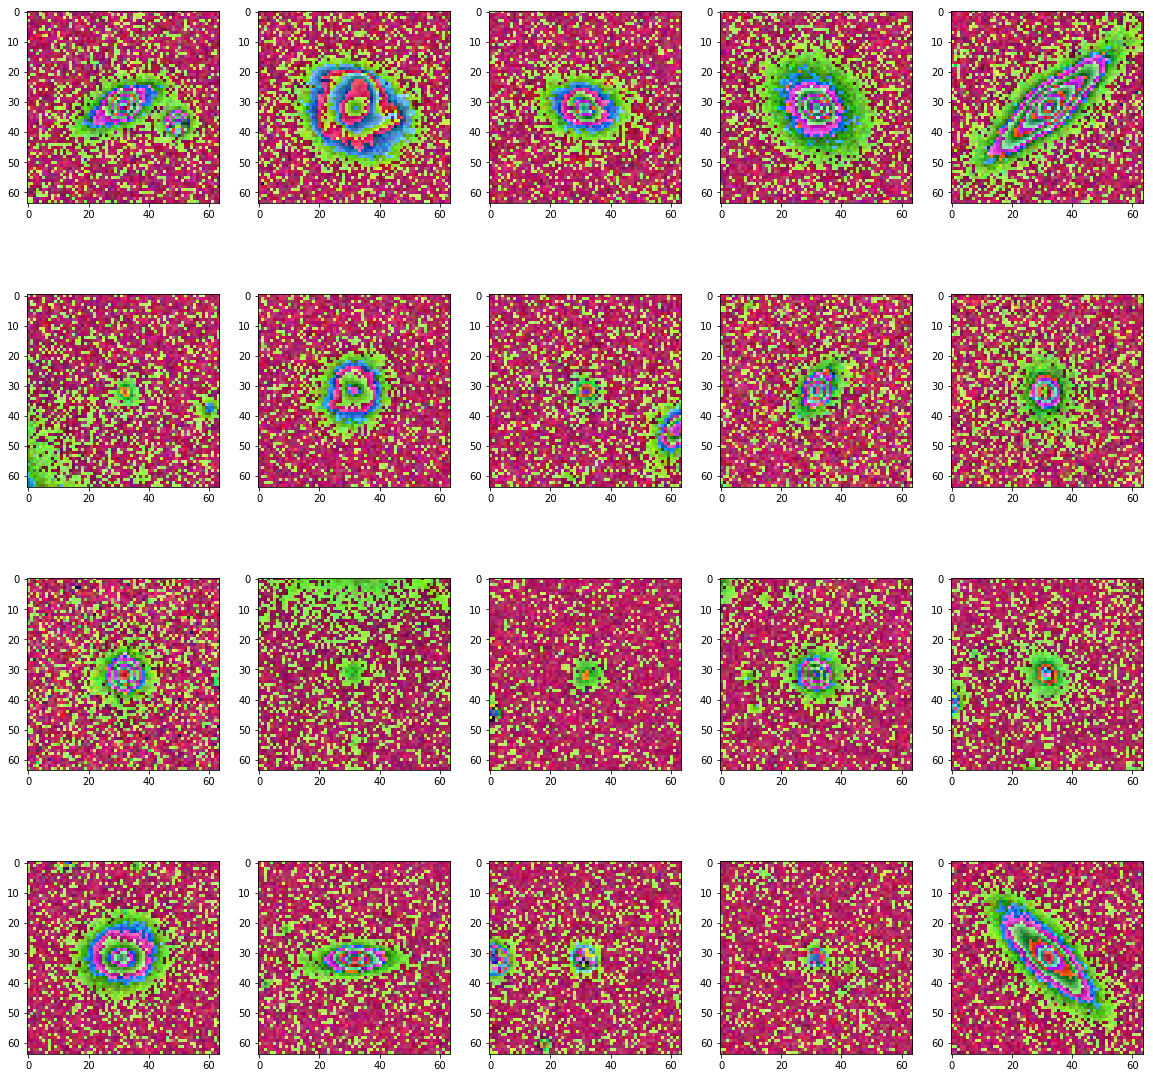

In [30]:
plt.figure(figsize=(20, 20))
for number in range(20):
    ax = plt.subplot(4,5,number+1)
    plt.imshow(train_data[number])
plt.show()

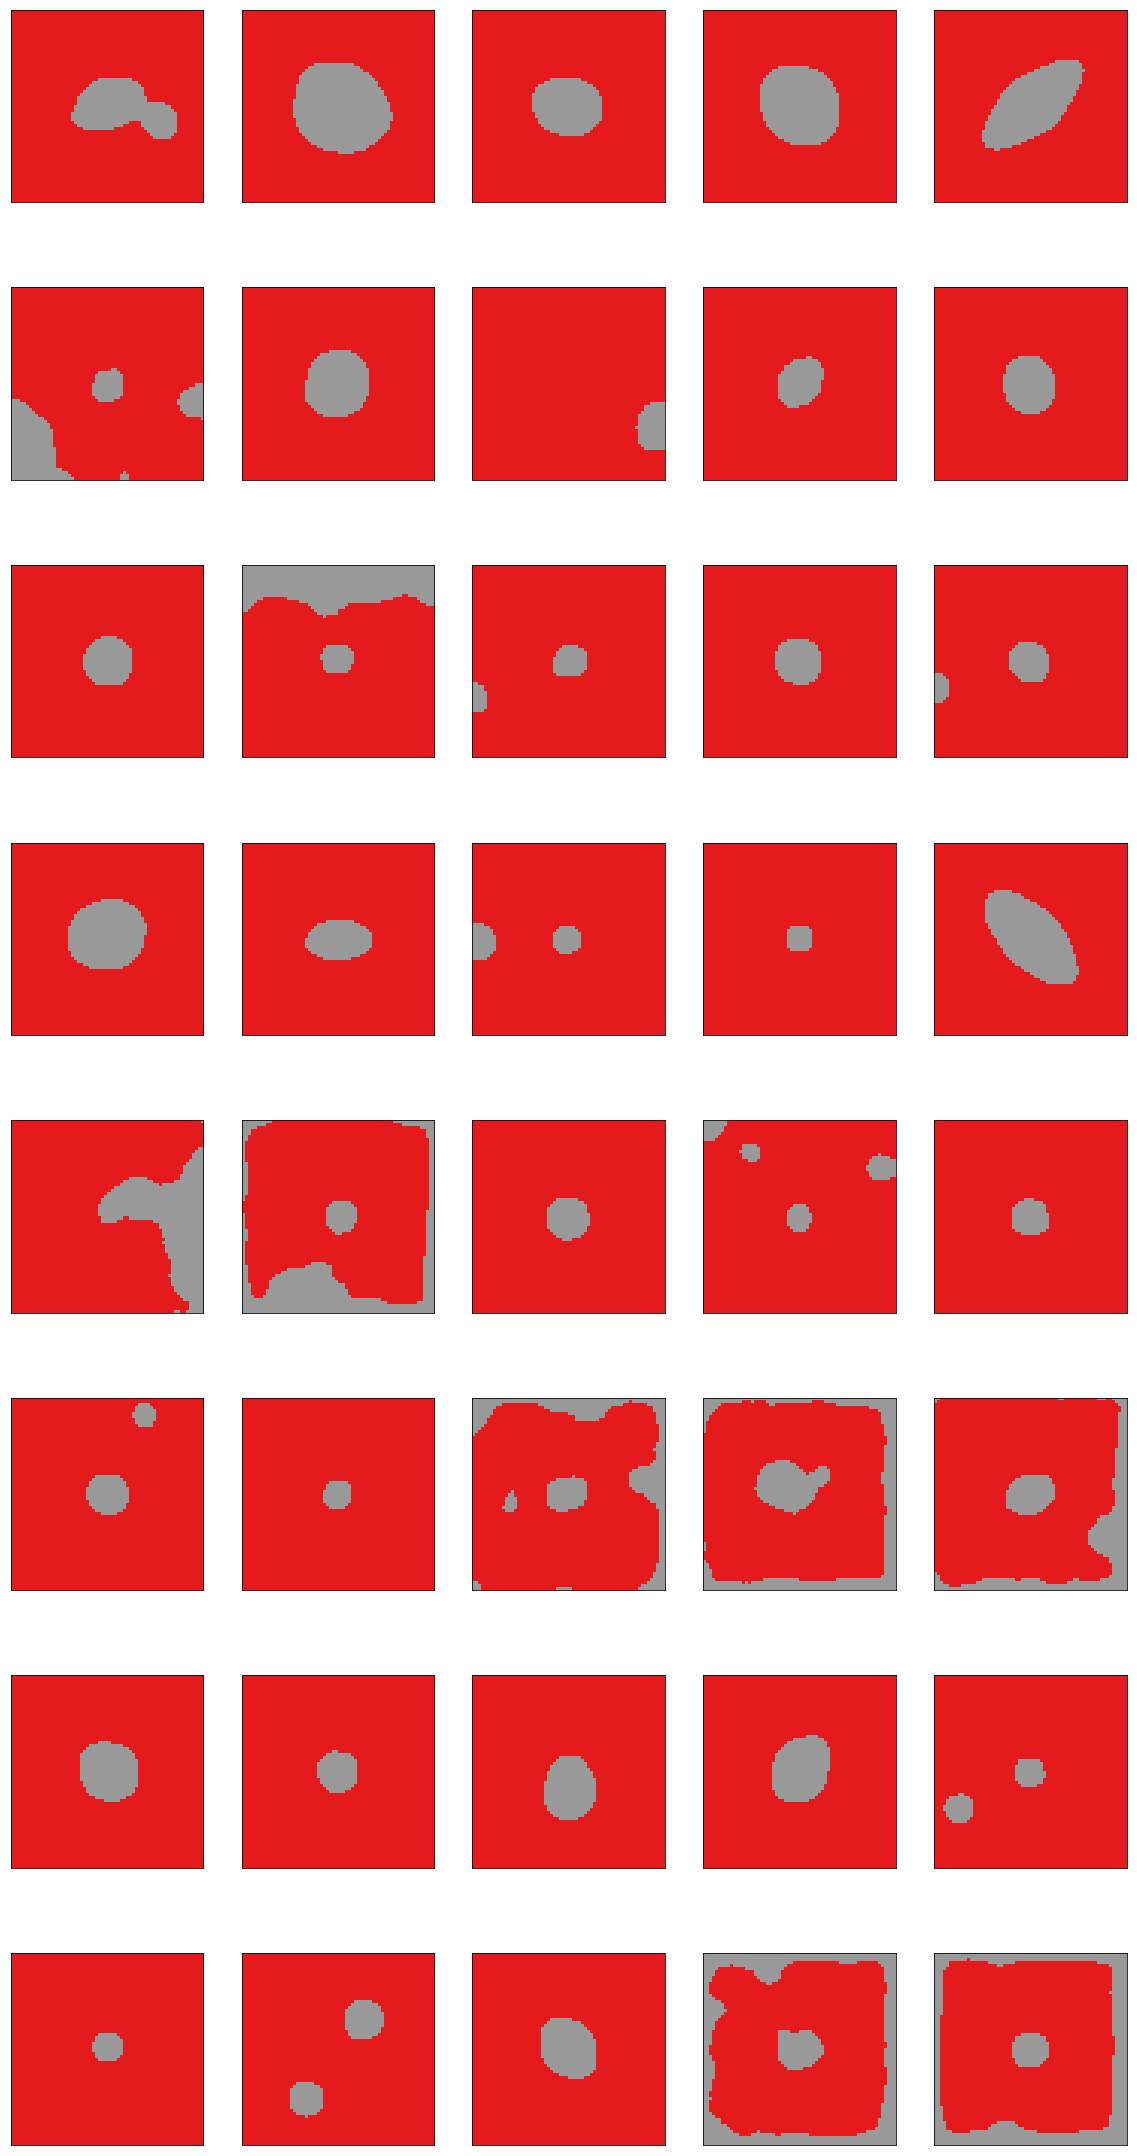

In [38]:
fig = plt.figure(figsize=(20, 40))
for number in range(40):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-10):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    if np.mean(cluster_labels)>0.5:
        cluster_labels = -cluster_labels
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(8,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

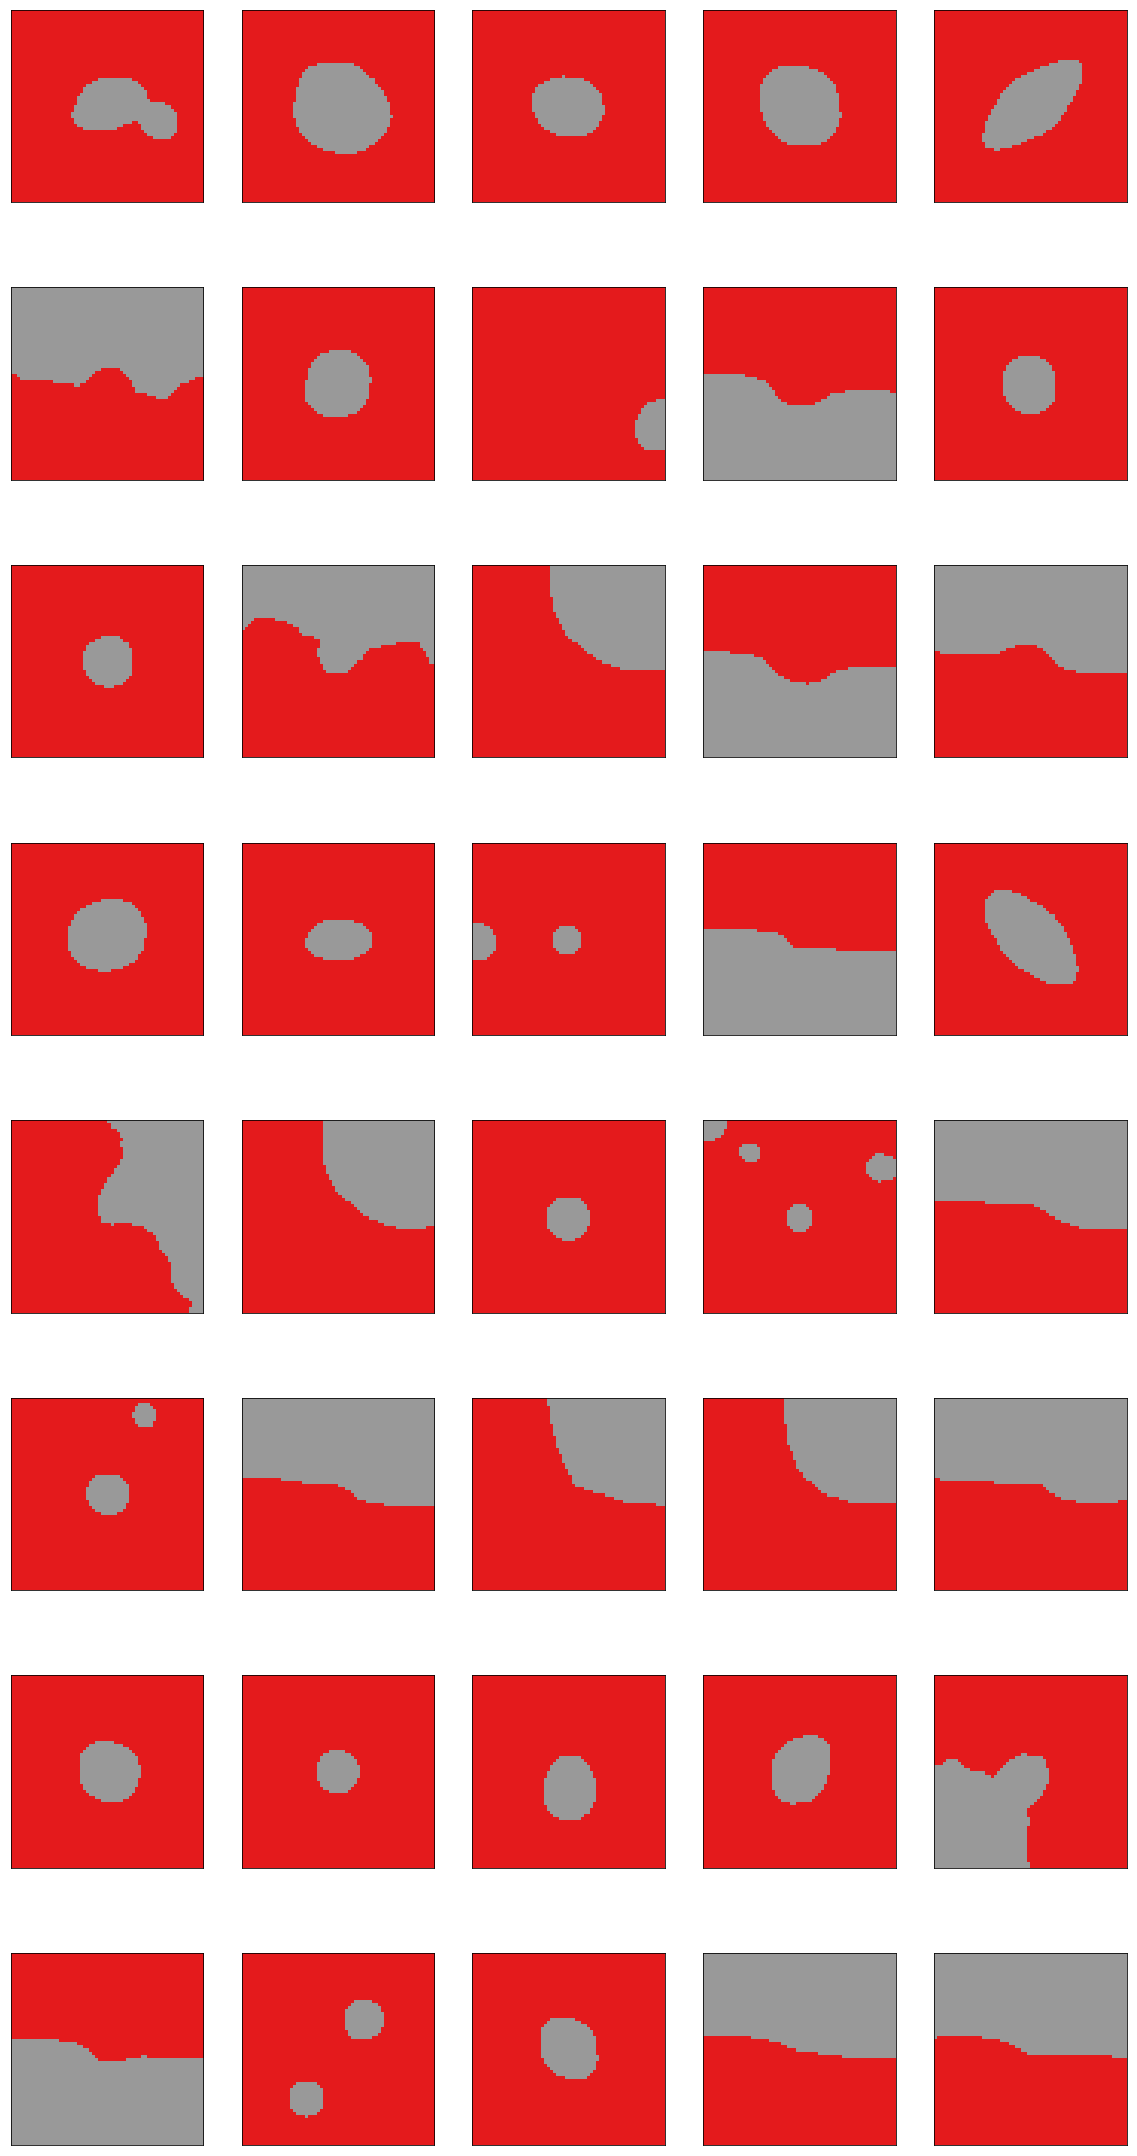

In [39]:
fig = plt.figure(figsize=(20, 40))
for number in range(40):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    if np.mean(cluster_labels)>0.5:
        cluster_labels = -cluster_labels
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(8,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()